# analysis examples

following the diagram

### libraries

In [3]:
from utilities import *

03-Sep-25 11:03:47 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


### downloading files from zenodo

https://zenodo.org/records/16037033

only the images necessary for image and picture analysis

In [24]:
path_name = get_zenodo('example')

7 file - downloading to c:\Users\USUARIO\Documents\github\MitoLandscape\example_data
downloading: example171_MITOBIN.tif
downloading: example_VENTRICLE.tif
downloading: example85_MITOBIN.tif
downloading: example_CELLS.tif
downloading: example_MITOBIN.h5
downloading: example_MITO.tif
downloading: example_SOMAS.tif
download complete


## core mito analysis

In [4]:
path_name = 'example_data/'

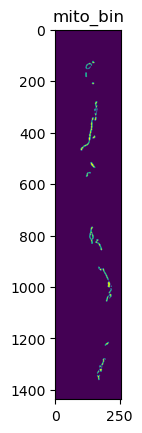


29 mitochondria
dict_keys(['coords', 'volume', 'length', 'diameter', 'surface', 'sphericity', 'skel_voxels', 'branches', 'junctions', 'endpoints'])


In [5]:
# getting the MITO.tif because contains pixel metadata information
_, res = get_picture(path_name + '/example_MITO.tif')

# mitochondria segmentation
mito_bin, _ = get_picture(path_name + '/example171_MITOBIN.tif')
show_pic(mito_bin, "mito_bin")

element_n, mito_output, mito_G = mito_analysis(mito_bin, res, minimum_vol=0)

print(f'{element_n} mitochondria')
print(mito_output.keys())

## cell without compartments/processes

### reding cell segmentations and selecting cell of interest

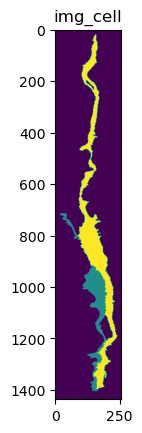

c:\Users\USUARIO\miniconda3\envs\MitoLandscape-env\Lib\site-packages\aicsimageio\readers\tiff_reader.py:148: UserWarning: Could not parse tiff pixel size: 'unit'
  warnings.warn(f"Could not parse tiff pixel size: {e}")


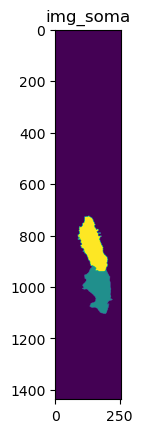

In [ ]:
# image contains 2 cell
img_cell = get_picture(path_name + '/example_CELLS.tif')[0]

info_cell = get_masks(img_cell)

# labels of the cells
cell_labels = info_cell[0]
# array with cell masks
cell_masks = info_cell[2]
show_pic(img_cell, 'img_cell')

img_soma = get_picture(path_name + '/example_SOMAS.tif')[0]
show_pic(img_soma, 'img_soma')

### focus on a specific cell

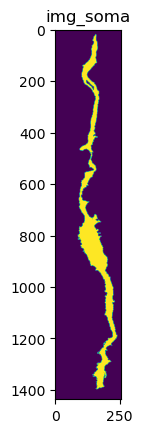

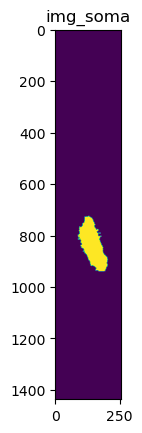

In [8]:
# let's focus only on the second cell
cell_label = cell_labels[1]
cell_mask = cell_masks[1]
show_pic(cell_mask, 'img_soma')


# keeping only the soma corresponding to the second label
soma_mask = img_soma == cell_label
show_pic(soma_mask, 'img_soma')

### distance from soma

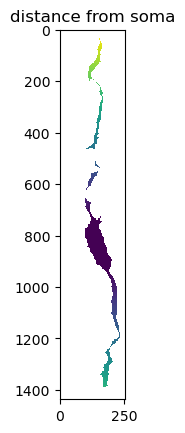

In [9]:
# calculating distance from the soma
soma_dist = geodesic_dist(cell_mask, soma_mask, res)
show_pic(soma_dist, 'distance from soma')

### analysis

In [10]:
results_cell, results_mito_cell = cell_analysis(
    mito_bin = mito_bin,            # mito_bin imported is already for this specific cell
    label_masks = cell_mask,        # we can use the cell mask itself if we don't have compartments
    soma_dist = soma_dist,          # distance from soma or nucleus can be used
    res = res,
    minimum_vol = 0
)

print(results_cell)

# the other table contains info of individual mitochondria
# print(results_mito_cell.columns)


  compartment     volume  mito_volume  avg_mito_volume     length  num_mito  \
0        True  38.848206     1.304359         0.044978  26.595724      29.0   

   num_p  num_r  num_n  mito_length  ...  tot_surface  avg_surface  \
0    2.0   22.0    5.0    38.436146  ...    26.437208     0.911628   

   avg_sphericity  tot_n_branches  avg_n_branches  avg_branches_length  \
0        0.272257            40.0         1.37931             0.960904   

   tot_n_junctions  avg_n_junctions  tot_n_endpoints  avg_n_endpoints  
0              8.0         0.275862             56.0         1.931034  

[1 rows x 23 columns]


c:\Users\USUARIO\Documents\github\MitoLandscape\utilities.py:767: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_mito_cell = results_mito_cell.replace([np.inf, -np.inf], np.nan)


## cell with compartments/processes

this specific example contains processes

### compartment labeling

4 compartments


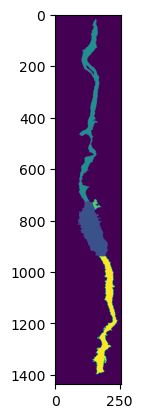

In [ ]:
cell_compartments, n_compartments = cell_annotation(cell_mask, soma_mask)   # this requires the soma, because processes are considered as disconnected compartments originating from the soma

print(f'{n_compartments} compartments')
show_pic(cell_compartments, 'compartments', palette = 'magma')

### analysis

In [12]:
results_cell, results_mito_cell = cell_analysis(
    mito_bin = mito_bin,            # mito_bin imported is already for this specific cell
    label_masks = cell_compartments,        # we use the previously calculated compartments
    soma_dist = soma_dist,          # distance from soma or nucleus can be used
    res = res,
    minimum_vol = 0
)

print(results_cell)


   compartment     volume  mito_volume  avg_mito_volume     length  num_mito  \
0          1.0  19.743834     0.273232         0.068308   0.000000       4.0   
1          2.0   8.169335     0.625155         0.048089  26.579083      13.0   
2          3.0   0.241239     0.000000              NaN   0.885695       0.0   
3          4.0  10.693799     0.405973         0.033831  17.484170      12.0   

   num_p  num_r  num_n  mito_length  ...  tot_surface  avg_surface  \
0    0.0    3.0    1.0     8.882512  ...     5.521028     1.380257   
1    2.0    9.0    2.0    18.451419  ...    12.458885     0.958376   
2    0.0    0.0    0.0     0.000000  ...     0.000000          NaN   
3    0.0   10.0    2.0    11.102215  ...     8.457296     0.704775   

   avg_sphericity  tot_n_branches  avg_n_branches  avg_branches_length  \
0        0.164494             7.0        1.750000             1.268930   
1        0.275313            16.0        1.230769             1.153214   
2             NaN        

## apical radial glia (ARG)

apical radial glia cells have two processes, one apical, one basal

we can automatically identify them by their position relative to the ventricle

### loading ventricle mask

In [13]:
img_vent = get_picture(path_name + '/example_VENTRICLE.tif')[0]

### distance from ventricle

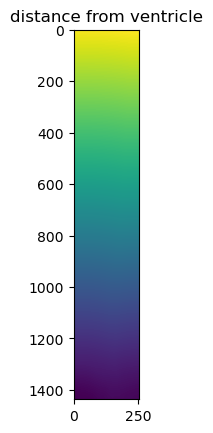

In [14]:
# using simple euclidean distance
vent_dist = distance_transform_edt(~img_vent, sampling= res)
show_pic(vent_dist, 'distance from ventricle')

### ARG compartment calculation

apical and basal processes

soma divided into two halves

 - apical soma: label 1
 - basal soma: label 2
 - apical process: label 3
 - basal process: label 4

soma is 19.34 μm from the ventricle


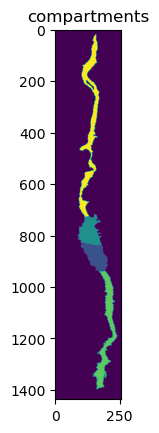

In [ ]:
# annotating the compartments
# cell_dist is the distance of the soma from the ventricle
comp_labels, cell_dist = apical_progenitor_compartment_annotation(cell_mask, soma_mask, soma_dist, vent_dist)


print(f'soma is {cell_dist:.2f} μm from the ventricle')
show_pic(comp_labels, 'compartments', palette = 'magma')

### analysis

In [17]:
results_cell, results_mito_cell = cell_analysis(
    mito_bin = mito_bin,            # mito_bin imported is already for this specific cell
    label_masks = comp_labels,        # we use the previously calculated compartments
    soma_dist = soma_dist,          # distance from soma or nucleus can be used
    res = res,
    minimum_vol = 0
)

print(results_cell)


   compartment     volume  mito_volume  avg_mito_volume     length  num_mito  \
0          1.0  11.221583     0.111280         0.037093   0.000000       3.0   
1          2.0   8.763490     0.161952         0.161952   0.000000       1.0   
2          3.0  10.693799     0.405973         0.033831  17.484170      12.0   
3          4.0   8.169335     0.625155         0.048089  26.579083      13.0   

   num_p  num_r  num_n  mito_length  ...  tot_surface  avg_surface  \
0    0.0    3.0    0.0     3.501845  ...     2.326051     0.775350   
1    0.0    0.0    1.0     5.380667  ...     3.194977     3.194977   
2    0.0   10.0    2.0    11.102215  ...     8.457296     0.704775   
3    2.0    9.0    2.0    18.451419  ...    12.458885     0.958376   

   avg_sphericity  tot_n_branches  avg_n_branches  avg_branches_length  \
0        0.271520             3.0        1.000000             1.167282   
1        0.090954             4.0        4.000000             1.345167   
2        0.340080        

## mitochondrial profile along processes

 - apical process: label 3
 - basal process: label 4

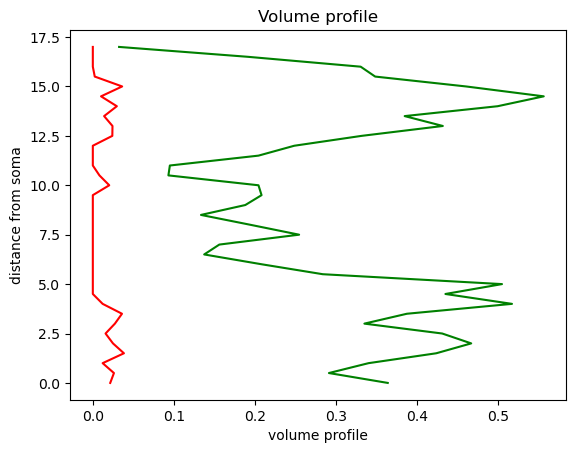

In [9]:
# analysis of the mitochondrial volume along the apical process
a_range, a_data, a_mito_data = process_analysis(comp_labels == 3, soma_dist, mito_bin, res)


plt.title('Volume profile')
plt.plot(a_data, a_range, label='cell', color='green')
plt.plot(a_mito_data, a_range, label='mito', color='red')
plt.xlabel("volume profile")
plt.ylabel("distance from soma")
plt.show()

## branching processes

In [ ]:
pic_name = 'pc_neuron'

path_name = get_zenodo(pic_name)

resolution: (0.035320000974832025, 0.035320000974832025, 0.159452)


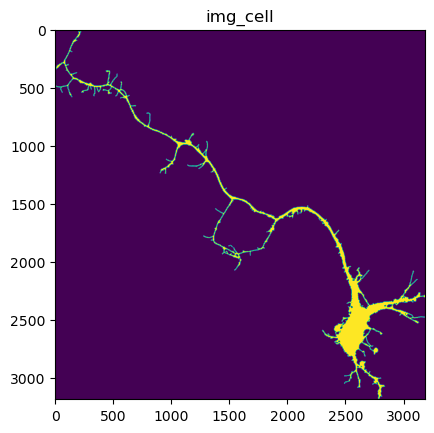

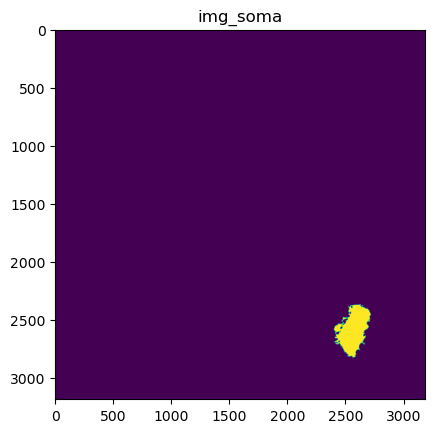

In [ ]:
_, res = get_picture(path_name + f'/{pic_name}_GFP.tif')
print(f'resolution: {res}')


img_cell, _ = get_picture(path_name + f'/{pic_name}_CELL.tif')

info_cell = get_masks(img_cell)

# labels of the cells
cell_labels = info_cell[0]
# array with cell masks
cell_masks = info_cell[2]
show_pic(img_cell, 'img_cell')

img_soma = get_picture(path_name + f'/{pic_name}_SOMA.tif')[0]
show_pic(img_soma, 'img_soma')

# let's focus on the only cell
cell_label = cell_labels[0]
cell_mask = cell_masks[0]

soma_mask = img_soma.astype(bool)

### compartment labeling

compartment labels: [1 2 3 4 5 6 7 8]


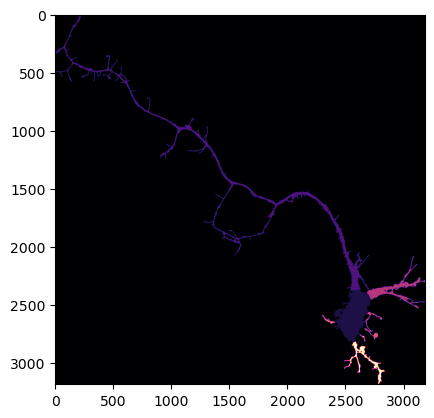

In [21]:
compartment_annotation, _ = cell_annotation(cell_mask, soma_mask)

print(f'compartment labels: {np.unique(compartment_annotation)[1:]}')
show_pic(compartment_annotation, palette = 'magma')

### Strahler analysis of branching structure

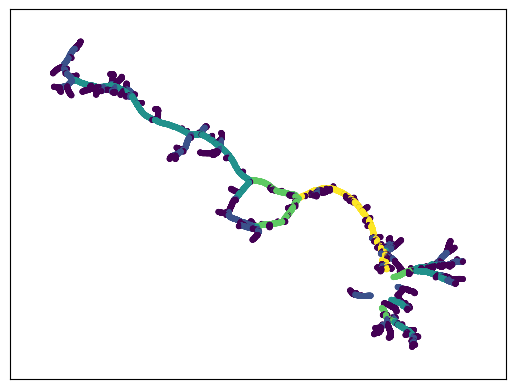

1: 289
2: 55
3: 10
4: 4
5: 1


In [22]:
branching_df, annotated_G = strahler_analysis(cell_mask, soma_mask, res, compartment_annotation, show = True)

### whole cell labeling from Strahler analysis

it might take a long time (~1h)

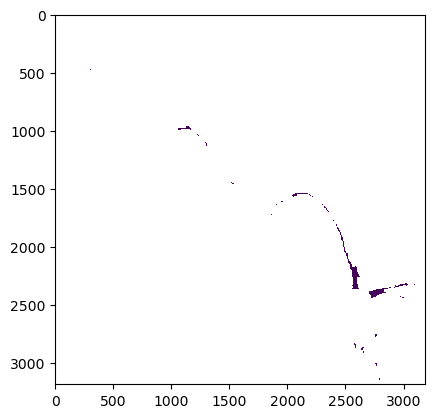

In [23]:
annotated_map = annotate_from_network(cell_mask, soma_mask, annotated_G, l='strahler_id')

show_pic(annotated_map)

### analysis

In [24]:
img_mito = read_h5(path_name + '/pc_neuron_MITOBIN.h5')
mito_bin = img_mito.astype(bool)

soma_dist = geodesic_dist(cell_mask, soma_mask, res)

# cell analysis
results_cell, results_mito_cell = cell_analysis(mito_bin, annotated_map, soma_dist, res)


print(results_cell)

c:\Users\USUARIO\miniconda3\envs\MitoLandscape-env\Lib\site-packages\pandas\core\internals\blocks.py:1429: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = casted
c:\Users\USUARIO\miniconda3\envs\MitoLandscape-env\Lib\site-packages\pandas\core\internals\blocks.py:1429: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = casted
c:\Users\USUARIO\miniconda3\envs\MitoLandscape-env\Lib\site-packages\pandas\core\internals\blocks.py:1429: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = casted
c:\Users\USUARIO\miniconda3\envs\MitoLandscape-env\Lib\site-packages\pandas\core\internals\blocks.py:1429: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = casted
c:\Users\USUARIO\miniconda3\envs\MitoLandscape-env\Lib\site-packages\pandas\core\internals\blocks.py:1429: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = casted
c:\Users\USUARIO\miniconda3\envs\MitoLan

InvalidIndexError: --